# Urban Sound CNN Classification

### Introduction

This Jupyter notebook was created by Filipe Barros, Gonçalo Arrobas and João Barão for the Machine Learning II.

### Authorship

Author: Filipe Barros, Gonçalo Arrobas and João Barão
University: Faculty of Science from University of Porto
Course: Machine Learning II
Sound Classification Problem

For this project, the students were tasked with the development of a deed learning model for audio classification. The data from the UrbanSound8K dataset was used throughout the development of this project. This dataset contains a total of 8732 labeled audio recordings of urban sounds, each with a duration of up to four seconds. Each excerpts has been labeled with one of the following classes:

0 = air_conditioner

1 = car_horn

2 = children_playing

3 = dog_bark

4 = drilling

5 = engine_idling

6 = gun_shot

7 = jackhammer

8 = siren

9 = street_music

The objective of this project relies on defining, compiling, training and evaluating two Deep Learning (DL) classifiers. The DL model types to be considered are:

Multilayer Perceptron (MLP)
Convolutional Neural Network (CNN)
Recurrent Neural Network (RNN)

### Import Statements

In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras import Sequential, Input, regularizers
import numpy as np
from keras.models import Sequential
from keras.layers import Input,Dense, Conv1D, Conv2D, MaxPooling2D
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, MaxPooling1D, Conv1D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from keras_tuner import Hyperband
from utils import build_model_1d, build_model_mfcc, build_model_mel

### Data Analysis

In [2]:
print("Loading CSV file {}".format('UrbanSound8K.csv'))

# Load metadata as a Pandas dataframe
metadata = pd.read_csv('UrbanSound8K.csv')

# Examine dataframe's head
metadata.head()

Loading CSV file UrbanSound8K.csv


,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


#### Class Distribution

In [5]:
metadata['class'].value_counts()

class
dog_bark            1000
children_playing    1000
air_conditioner     1000
street_music        1000
engine_idling       1000
jackhammer          1000
drilling            1000
siren                929
car_horn             429
gun_shot             374
Name: count, dtype: int64

### Feature Engineering

In [2]:
X_folds_1d = []
y_folds_1d = []

le = LabelEncoder()

for i in range(10):
    X_fold = np.load(f'fold{i + 1}1d_features.npy', allow_pickle=True)
    y_fold = np.load(f'fold{i + 1}1d_labels.npy', allow_pickle=True)
    y_fold = to_categorical(le.fit_transform(y_fold))
    
    X_folds_1d.append(X_fold)
    y_folds_1d.append(y_fold)

In [3]:
# Inicializar listas vazias para carregar os dados
X_folds_mel = []
y_folds_mel = []


le = LabelEncoder()

# Carregar e plotar cada fold
for i in range(10):
    X_fold = np.load(f'fold{i + 1}mel40_features.npy', allow_pickle=True)
    y_fold = np.load(f'fold{i + 1}mel40_labels.npy', allow_pickle=True)

    scalers = {}
    for i in range(X_fold.shape[1]):
        scalers[i] = StandardScaler()
        X_fold[:, i, :] = scalers[i].fit_transform(X_fold[:, i, :])
    y_fold = to_categorical(le.fit_transform(y_fold))

    X_folds_mel.append(X_fold)
    y_folds_mel.append(y_fold)

In [2]:
# Inicializar listas vazias para carregar os dados
X_folds_mfcc = []
y_folds_mfcc = []


le = LabelEncoder()

# Carregar e plotar cada fold
for i in range(10):
    X_fold = np.load(f'fold_{i + 1}_40mfcc_features.npy', allow_pickle=True)
    y_fold = np.load(f'fold_{i + 1}_40mfcc_labels.npy', allow_pickle=True)

    scalers = {}
    for i in range(X_fold.shape[1]):
        scalers[i] = StandardScaler()
        X_fold[:, i, :] = scalers[i].fit_transform(X_fold[:, i, :])
    y_fold = to_categorical(le.fit_transform(y_fold))

    X_folds_mfcc.append(X_fold)
    y_folds_mfcc.append(y_fold)

### Model Architectures

##### CNN - 1D Architecture

In [9]:
# Define the CNN model with L2 regularization
def create_model_1d():
    num_classes = 10  # Predicting 10 classes
    l2_lambda = 0.01  # L2 regularization coefficient
    input_shape = (4000 , 1)
    model = Sequential()

    # First convolutional block with L2 regularization
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', 
                     input_shape=input_shape, kernel_regularizer=l2(l2_lambda)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))

    # Second convolutional block with L2 regularization
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', 
                     kernel_regularizer=l2(l2_lambda)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))

    # Third convolutional block with L2 regularization
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', 
                     kernel_regularizer=l2(l2_lambda)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))

    # Flatten and add fully connected layers with L2 regularization
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(l2_lambda)))
    model.add(Dropout(0.5))  # Dropout for regularization

    # Output layer with L2 regularization
    model.add(Dense(num_classes, activation='softmax', kernel_regularizer=l2(l2_lambda)))
    optimizer_adam = Adam(learning_rate=0.00025)
    # Compile the model
    model.compile(optimizer=optimizer_adam,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

##### CNN - 2D Mel Spectograms Architecture

In [8]:
def create_model_2d_mel():
    model = Sequential()

    # Input layer
    model.add(Input(shape=(40, 174, 1)))

    # First convolutional block with L2 regularization
    model.add(Conv2D(
        filters=64,  # Reduced the number of filters
        kernel_size=(5, 5),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.048)
    ))

    # Second convolutional block with L2 regularization
    model.add(Conv2D(
        filters=32,  # Reduced the number of filters
        kernel_size=(3, 3),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.048)
    ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten the output
    model.add(Flatten())

    # Dense layer with L2 regularization
    model.add(Dense(
        units=64,  # Reduced the number of units
        activation='relu',
        kernel_regularizer=regularizers.l2(0.048)
    ))

    # Dropout layer for additional regularization
    model.add(Dropout(rate=0.3))

    # Output layer
    model.add(Dense(10, activation='softmax'))

    # Compile the model
    learning_rate = 0.0007  # Found through hyperparameter tuning

    optimizer_sgd = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    optimizer_adam = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer_sgd, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


##### CNN 2D - MFFCs Architecture

In [3]:
def create_model_2d():
    model = Sequential()

    # Input layer
    model.add(Input(shape=(40, 174, 1)))

    # First convolutional block with L2 regularization
    model.add(Conv2D(
        filters=64,  # Reduced the number of filters
        kernel_size=(5, 5),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.02)
    ))

    # Second convolutional block with L2 regularization
    model.add(Conv2D(
        filters=64,  # Reduced the number of filters
        kernel_size=(3, 3),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.02)
    ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten the output
    model.add(Flatten())

    # Dense layer with L2 regularization
    model.add(Dense(
        units=32,  # Reduced the number of units
        activation='relu',
        kernel_regularizer=regularizers.l2(0.02)
    ))

    # Dropout layer for additional regularization
    model.add(Dropout(rate=0.4))

    # Output layer
    model.add(Dense(10, activation='softmax'))

    # Compile the model
    learning_rate = 0.00048  # Found through hyperparameter tuning

    optimizer_sgd = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    optimizer_adam = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer_sgd, loss='categorical_crossentropy', metrics=['accuracy'])

    return model


### Model Experimentation

##### CNN - 1D Experimentation

We started by implementing a simpler version of a 1D Convolutional Neural Network (CNN) using the audio signal, which was downsampled to a sampling rate (sr) of 1000 Hz to reduce computational costs. This downsampling was necessary to enable efficient training and testing of the network without significantly compromising the relevant information in the audio data.

The model begins with three sequential convolutional blocks, each consisting of a 1D convolutional layer, batch normalization, and max-pooling. L2 regularization with a coefficient of 0.01 is applied to prevent overfitting by penalizing large weights. Batch normalization stabilizes training by normalizing the output, and max-pooling reduces the temporal dimension, making the network computationally efficient while preserving key features. The second and third convolutional blocks progressively increase the number of filters to 64 and 128, respectively, allowing the model to extract more complex patterns such as frequency variations and rhythmic structures, essential for distinguishing between different audio classes.

After the convolutional blocks, the feature map is flattened and passed through a fully connected layer with 128 neurons and ReLU activation, which refines the learned representations. L2 regularization and a dropout rate of 0.5 are applied to this layer to further reduce overfitting by promoting generalization.

In addition to the initial model, we implemented a new version of the 1D CNN that utilizes **moving average envelopes** applied to the audio signal. This technique smooths the raw waveform by averaging the signal over a sliding window, effectively capturing the overall amplitude variations and energy distribution across time while filtering out high-frequency noise. By using the envelope of the signal, the network focuses on the macro-level dynamics of the audio, such as transitions, rhythmic patterns, and amplitude modulations, rather than being influenced by fine-grained, potentially irrelevant details. This approach enhances the model's robustness to noise and small temporal variations, making it better suited for tasks where the overall structure of the audio signal carries more predictive information than the fine details. Additionally, the moving average envelope reduces the complexity of the input data, which can lead to faster training and improved generalization, particularly in scenarios where the dataset may have limited diversity or contain noisy samples.

The results were obtained were the following:

- CNN 1D - Audio Signal

![Description of the image](1d_original_no.png)

- CNN 1D - Envelope Technique

![Description of the image](1denvelope.png)

##### CNN - 2D MFCCs Experimentation

We further extended our approach by implementing a 2D Convolutional Neural Network (CNN) to work with the Mel-Frequency Cepstral Coefficients (MFCCs) extracted from the audio signals. In this version, we experimented with two different configurations of MFCC features: one with the standard 13 coefficients, commonly used for speech-related tasks, and another with 40 coefficients, which provides a more detailed representation of the spectral characteristics of the audio. MFCCs effectively transform the audio signal into a time-frequency representation that captures the perceptual aspects of sound, making them well-suited for classification tasks involving human auditory perception. 

This **2D Convolutional Neural Network** begins with an input layer, followed by three convolutional blocks designed to extract spatial features while incorporating L2 regularization to prevent overfitting. The first block uses 64 filters with a (5, 5) kernel, followed by two additional blocks with 64 filters and a (3, 3) kernel each. ReLU activation is applied after each convolutional layer to introduce non-linearity, and a MaxPooling layer with a (2, 2) window reduces the spatial dimensions, enhancing feature abstraction.

After the convolutional layers, the output is flattened into a 1D feature vector, which is passed through a fully connected dense layer with 80 units, ReLU activation, and L2 regularization (factor 0.02). To further improve generalization, a dropout layer with a 40% rate is applied. Finally, a dense output layer with 10 units and a softmax activation predicts class probabilities for multi-class classification tasks. The model is compiled using the Stochastic Gradient Descent (SGD) optimizer with a learning rate of 0.0005 and momentum of 0.9, targeting categorical cross-entropy as the loss function and optimizing for accuracy.

The results obtained are presented below:

- CNN 2D - 13 MFCCs

![Description of the image](13mfcc_no.png)

- CNN 2D - 40 MFCCs

![Description of the image](Results/40mfcc_no.png)


We further explored the 40 MFCC coefficients in our model, as they provide a more detailed and nuanced representation of the audio signal compared to the standard 13 MFCCs. This additional resolution allows the model to capture finer spectral features, which can be especially valuable for tasks that involve complex or subtle patterns in the audio, such as distinguishing between similar sound classes or dealing with varying acoustic conditions. To enhance the model's robustness and improve its generalization, we also applied data augmentation techniques, specifically noise introduction, pitch shifting, and time stretching.

- CNN 2D - 40 MFCCs

![Description of the image](Results/40mfcc_no.png)

- CNN 2D - 40 MFCCSs with Data Augmentation

![Description of the image](Results/40mfcc_data.png)

Stochastic Gradient Descent (SGD) and Adam are both popular optimization techniques, but they differ in how they adjust learning rates during training. SGD updates model parameters using one data sample at a time, which leads to faster updates but can result in noisy and unstable convergence. Adam (Adaptive Moment Estimation), on the other hand, adapts the learning rate for each parameter based on estimates of first and second moments (mean and variance), which allows it to converge faster and more smoothly, especially in complex models. While SGD is simpler and computationally efficient, Adam is often preferred for more complicated tasks due to its adaptive nature. Given the advantages of both, we will experiment with both SGD and Adam to assess which optimizer leads to faster and more stable convergence for our dataset.


- CNN 2D - 40 MFCCs with SGD

![Description of the image](Results/40mfcc_no.png)

- CNN 2D - 40 MFCCs with Adam

![Description of the image](Results/140mfcc_no.png)

##### CNN - 2D Mel Spectograms Experimentation

In this experiment, we will use **mel spectrograms** with **40, 64 and 80 frequency bands** to represent audio signals. Mel spectrograms are widely used in audio processing because they model human auditory perception more accurately than traditional spectrograms by mapping frequencies onto the mel scale, which emphasizes lower frequencies where human hearing is more sensitive. The choice of 64 bands provides a balance between resolution and computational efficiency: it captures sufficient detail to distinguish different audio features, such as pitch and timbre, while keeping the dimensionality low enough to reduce processing time. 

The results are presented below:

- CNN 2D - Mel Spectograms 40 bands

![Description of the image](40mel.png)

- CNN 2D - Mel Spectograms 64 bands

![Description of the image](melno.png)

- CNN 2D - Mel Spectograms 80 bands

![Description of the image](80mel.png)

### Hyperparameter Tuning

##### CNN - 1D Tuning

In [3]:
# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=5, # Stop after 5 epochs of no improvement
    restore_best_weights=True
)

# Define the tuner
tuner = Hyperband(
    build_model_1d,
    objective='val_accuracy',
    max_epochs=15,
    factor=3,
    directory='my_tuning_dir',
    project_name='1d_tuning'
)

# Define the training and validation data
X_val = X_folds_1d[0]
y_val = y_folds_1d[0]
X_train = np.concatenate([X_folds_1d[j] for j in range(10) if j != 0 and j != 1], axis=0)
y_train = np.concatenate([y_folds_1d[j] for j in range(10) if j != 0 and j != 1], axis=0)

# Run the tuner search with batch_size=128 and early stopping
tuner.search(
    X_train, 
    y_train, 
    epochs=15, 
    validation_data=(X_val, y_val),
    batch_size=256, 
    callbacks=[early_stopping]
)

Trial 20 Complete [00h 18m 13s]
val_accuracy: 0.04009163752198219

Best val_accuracy So Far: 0.1649484485387802
Total elapsed time: 02h 24m 01s

Search: Running Trial #21

Value             |Best Value So Far |Hyperparameter
64                |32                |conv_1_filters
0.0578            |0.0391            |l2_lambda
128               |128               |conv_2_filters
384               |384               |conv_3_filters
64                |192               |dense_units
0.3               |0.3               |dropout_rate
4.3389e-05        |0.0033963         |learning_rate
5                 |5                 |tuner/epochs
0                 |2                 |tuner/initial_epoch
1                 |2                 |tuner/bracket
0                 |1                 |tuner/round

Epoch 1/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 88s 3s/step - accuracy: 0.1867 - loss: 27.4840 - val_accuracy: 0.1145 - val_loss: 29.6425
Epoch 2/5
 4/28 ━━━━━━━━━━━━━━━━━━━━ 1:13 3s/step - accuracy: 0.2953 - loss:

KeyboardInterrupt: 

##### CNN 2D - Mel Spectograms Tuning

In [5]:
# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=5, # Stop after 5 epochs of no improvement
    restore_best_weights=True
)

# Define the tuner
tuner = Hyperband(
    build_model_mel,
    objective='val_accuracy',
    max_epochs=20,
    factor=3,
    directory='my_tuning_dir',
    project_name='mel_tuning'
)

# Define the training and validation data
X_val = X_folds_mel[0]
y_val = y_folds_mel[0]
X_train = np.concatenate([X_folds_mel[j] for j in range(10) if j != 0 and j != 1], axis=0)
y_train = np.concatenate([y_folds_mel[j] for j in range(10) if j != 0 and j != 1], axis=0)

# Run the tuner search with batch_size=128 and early stopping
tuner.search(
    X_train, 
    y_train, 
    epochs=20, 
    validation_data=(X_val, y_val),
    batch_size=128, 
    callbacks=[early_stopping]
)

Trial 30 Complete [00h 03m 31s]
val_accuracy: 0.5120275020599365

Best val_accuracy So Far: 0.6219931244850159
Total elapsed time: 01h 29m 00s


In [6]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print(f"Best number of filters in the first Conv2D layer: {best_hps.get('conv_1_filters')}")
print(f"Best L2 regularization for the first Conv2D layer: {best_hps.get('l2_lambda')}")
print(f"Best number of filters in the second Conv2D layer: {best_hps.get('conv_2_filters')}")
print(f"Best number of units in the Dense layer: {best_hps.get('dense_units')}")
print(f"Best dropout rate: {best_hps.get('dropout_rate')}")
print(f"Best learning rate: {best_hps.get('learning_rate')}")

Best number of filters in the first Conv2D layer: 64
Best L2 regularization for the first Conv2D layer: 0.0048000000000000004
Best number of filters in the second Conv2D layer: 32
Best number of units in the Dense layer: 64
Best dropout rate: 0.3
Best learning rate: 0.0006991836856342674


##### CNN 2D - MFCCs Tuning

In [3]:
# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=5, # Stop after 5 epochs of no improvement
    restore_best_weights=True
)

# Define the tuner
tuner = Hyperband(
    build_model_mfcc,
    objective='val_accuracy',
    max_epochs=30,
    factor=3,
    directory='my_tuning_dir',
    project_name='cnn_tuning'
)

# Define the training and validation data
X_val = X_folds_mfcc[0]
y_val = y_folds_mfcc[0]
X_train = np.concatenate([X_folds_mfcc[j] for j in range(10) if j != 0 and j != 1], axis=0)
y_train = np.concatenate([y_folds_mfcc[j] for j in range(10) if j != 0 and j != 1], axis=0)

# Run the tuner search with batch_size=128 and early stopping
tuner.search(
    X_train, 
    y_train, 
    epochs=30, 
    validation_data=(X_val, y_val),
    batch_size=128, 
    callbacks=[early_stopping]
)

Trial 90 Complete [00h 01m 19s]
val_accuracy: 0.4753722846508026

Best val_accuracy So Far: 0.5658648610115051
Total elapsed time: 01h 02m 17s


In [5]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print(f"Best number of filters in the first Conv2D layer: {best_hps.get('conv1_filters')}")
print(f"Best L2 regularization for the first Conv2D layer: {best_hps.get('l2')}")
print(f"Best number of filters in the second Conv2D layer: {best_hps.get('conv2_filters')}")
print(f"Best number of units in the Dense layer: {best_hps.get('dense_units')}")
print(f"Best dropout rate: {best_hps.get('dropout')}")
print(f"Best learning rate: {best_hps.get('learning_rate')}")


Best number of filters in the first Conv2D layer: 64
Best L2 regularization for the first Conv2D layer: 0.02
Best number of filters in the second Conv2D layer: 64
Best number of units in the Dense layer: 32
Best dropout rate: 0.4
Best learning rate: 0.00048047833322716955


### Model Analysis and Results

In [6]:
def plot_graphs(history, y_true, y_pred, class_labels):
    # Create a 1x3 grid for subplots
    fig, axs = plt.subplots(1, 3, figsize=(18, 4))

    # Plot accuracy values
    axs[0].plot(history.history['accuracy'])
    axs[0].plot(history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['Train', 'Validation'], loc='upper left')

    # Plot loss values
    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['Train', 'Validation'], loc='upper left')

    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, ax=axs[2])
    axs[2].set_title('Confusion Matrix')
    axs[2].set_xlabel('Predicted')
    axs[2].set_ylabel('True')

    # Adjust layout
    plt.tight_layout()
    plt.show()

##### CNN - 1D  Results


Training fold 1...
Epoch 1/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 36s 620ms/step - accuracy: 0.1714 - loss: 13.6766 - val_accuracy: 0.1025 - val_loss: 6.6162
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 34s 614ms/step - accuracy: 0.2015 - loss: 10.2737 - val_accuracy: 0.1351 - val_loss: 7.1720
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 34s 614ms/step - accuracy: 0.2033 - loss: 8.9388 - val_accuracy: 0.1351 - val_loss: 9.9003
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 34s 614ms/step - accuracy: 0.1985 - loss: 8.4091 - val_accuracy: 0.1126 - val_loss: 10.0407
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 34s 615ms/step - accuracy: 0.2095 - loss: 7.1418 - val_accuracy: 0.1126 - val_loss: 10.3477
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 34s 617ms/step - accuracy: 0.2154 - loss: 6.4828 - val_accuracy: 0.1464 - val_loss: 8.5863
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 34s 618ms/step - accuracy: 0.1993 - loss: 5.9130 - val_accuracy: 0.1137 - val_loss: 7.6799
Epoch 8/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 34s 613ms/step - accuracy: 0.2168 -

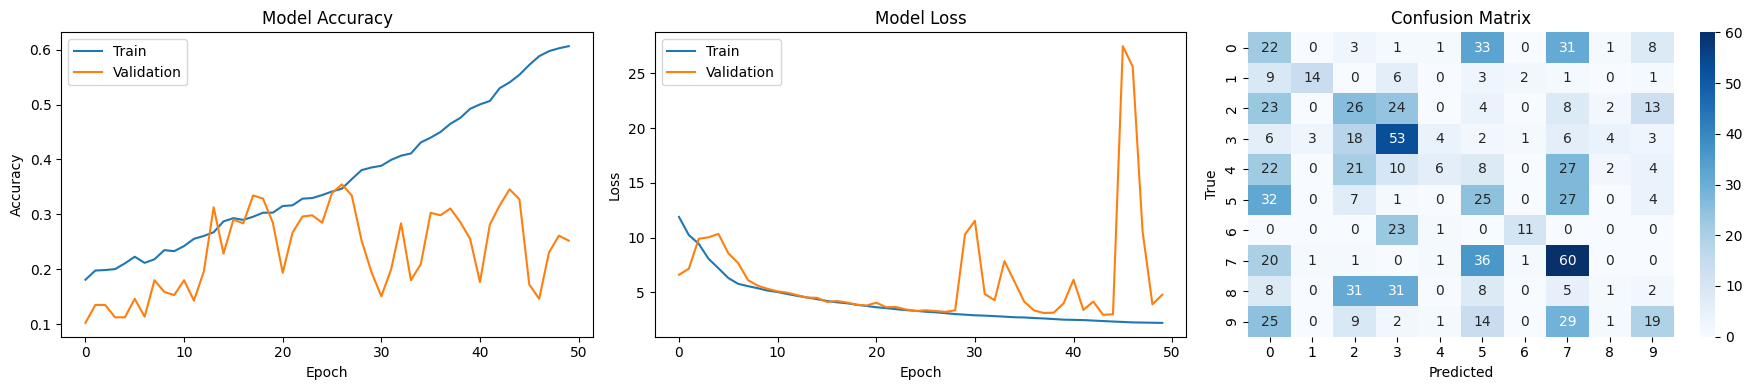

Fold 1 Test Accuracy: 0.2715

Training fold 2...
Epoch 1/50


c:\Users\Utilizador\anaconda3\envs\model\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 35s 613ms/step - accuracy: 0.1669 - loss: 14.8567 - val_accuracy: 0.1297 - val_loss: 6.2608
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 33s 599ms/step - accuracy: 0.1893 - loss: 11.6253 - val_accuracy: 0.1081 - val_loss: 6.5542
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 33s 603ms/step - accuracy: 0.1850 - loss: 11.3175 - val_accuracy: 0.1081 - val_loss: 7.0723
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 33s 603ms/step - accuracy: 0.2059 - loss: 10.3535 - val_accuracy: 0.1297 - val_loss: 6.3502
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 33s 598ms/step - accuracy: 0.2172 - loss: 7.9056 - val_accuracy: 0.1157 - val_loss: 6.3889
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 33s 601ms/step - accuracy: 0.2081 - loss: 7.1291 - val_accuracy: 0.1308 - val_loss: 6.0713
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 33s 601ms/step - accuracy: 0.2031 - loss: 6.9843 - val_accuracy: 0.1146 - val_loss: 5.8302
Epoch 8/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 34s 610ms/step - accuracy: 0.2283 - loss: 6.1849 - val_accuracy: 0

KeyboardInterrupt: 

In [12]:
num_folds = 10
fold_accuracies = []
early_stoppings=[]
for i in range(num_folds):
    early_stoppings.append(EarlyStopping(
        monitor='val_loss',  # Metric to monitor; commonly 'val_loss' or 'val_accuracy'
        patience=10 ,          # Number of epochs to wait after no improvement
        restore_best_weights=True,  # Restores model weights to the best epoch with the lowest monitored metric
        verbose=1            # Print messages when early stopping is triggered
    ))
    
y_test_multiclasses = []
predicted_labels_cnns = []
class_labels=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
for i in range(num_folds):
    # Define the test and validation indices
    test_idx = i
    val_idx = (i + 1) % num_folds
    
    # Split the data accordingly
    X_test = X_folds_1d[test_idx]
    y_test = y_folds_1d[test_idx]
    X_val = X_folds_1d[val_idx]
    y_val = y_folds_1d[val_idx]

    # Combine the remaining folds for training
    X_train = np.concatenate([X_folds_1d[j] for j in range(num_folds) if j != test_idx and j != val_idx], axis=0)
    y_train = np.concatenate([y_folds_1d[j] for j in range(num_folds) if j != test_idx and j != val_idx], axis=0)

    # Create a new model instance for each fold
    model = create_model_1d()
    
    # Train the model
    print(f"\nTraining fold {i + 1}...")
    history=model.fit(X_train, y_train, epochs=50, batch_size=128, validation_data=(X_val, y_val), verbose=1, callbacks=[early_stoppings[i]])
    model.save(f"model_fold{i}.keras")

    predictions_cnn = model.predict(X_test)
    predicted_labels_cnn = np.argmax(predictions_cnn, axis=1)

    y_test_multiclass = np.argmax(y_test, axis=1)
    
    if i==0:
        y_test_multiclasses = y_test_multiclass
        predicted_labels_cnns = predicted_labels_cnn
    else:
        y_test_multiclasses = np.concatenate((y_test_multiclasses, y_test_multiclass))
        predicted_labels_cnns = np.concatenate((predicted_labels_cnns, predicted_labels_cnn))

    plot_graphs(history, y_test_multiclass, predicted_labels_cnn, class_labels=class_labels)

    # Evaluate on the test set
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"Fold {i + 1} Test Accuracy: {test_acc:.4f}")
    
    # Save the accuracy for later analysis
    fold_accuracies.append(test_acc)

average_accuracy = np.mean(fold_accuracies)
print(f"\nAverage Accuracy across {num_folds} folds: {average_accuracy*100:.4f}%")
print(f"Standard Deviation: {np.std(fold_accuracies)*100:.4f}%")

# Print average accuracy across all folds
cm = confusion_matrix(y_test_multiclasses, predicted_labels_cnns)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

##### CNN - 2D Mel Spectograms Results


Training fold 1...
Epoch 1/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 25s 434ms/step - accuracy: 0.1743 - loss: 10.3800 - val_accuracy: 0.2511 - val_loss: 9.7026
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 24s 427ms/step - accuracy: 0.3275 - loss: 9.4858 - val_accuracy: 0.2950 - val_loss: 9.0633
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 23s 425ms/step - accuracy: 0.3872 - loss: 8.7987 - val_accuracy: 0.3851 - val_loss: 8.4733
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 23s 422ms/step - accuracy: 0.4345 - loss: 8.1805 - val_accuracy: 0.3649 - val_loss: 7.9333
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 23s 425ms/step - accuracy: 0.4696 - loss: 7.6551 - val_accuracy: 0.4212 - val_loss: 7.4485
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 24s 428ms/step - accuracy: 0.4961 - loss: 7.1479 - val_accuracy: 0.3682 - val_loss: 7.0402
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 23s 424ms/step - accuracy: 0.5120 - loss: 6.7122 - val_accuracy: 0.4358 - val_loss: 6.6098
Epoch 8/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 24s 428ms/step - accuracy: 0.5462 - lo

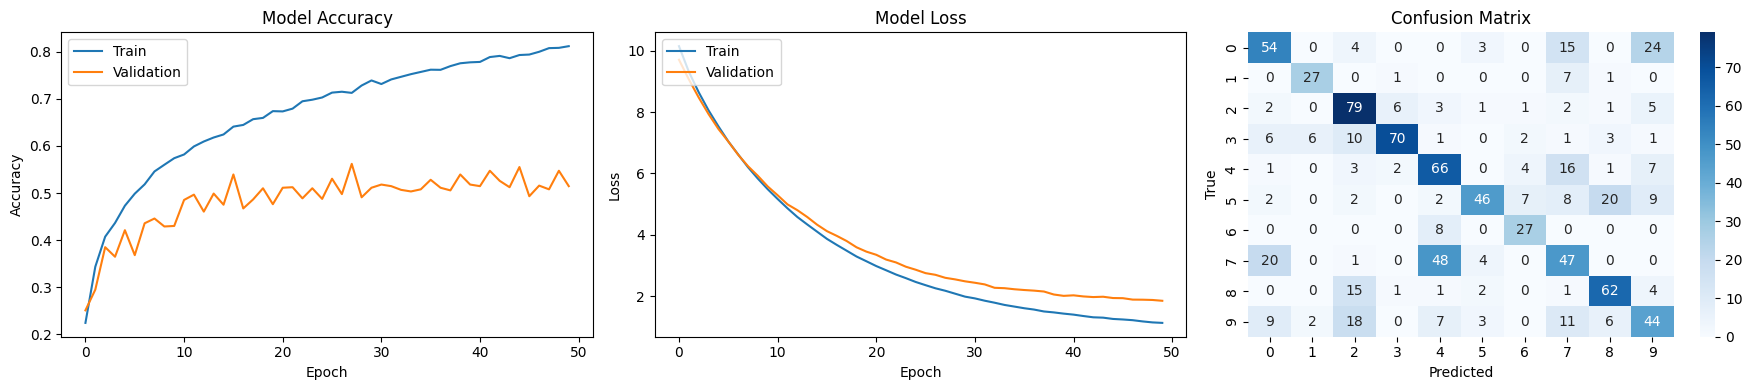

Fold 1 Test Accuracy: 0.5979

Training fold 2...
Epoch 1/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 31s 548ms/step - accuracy: 0.1842 - loss: 10.3909 - val_accuracy: 0.3276 - val_loss: 9.7007
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 33s 602ms/step - accuracy: 0.3275 - loss: 9.4920 - val_accuracy: 0.3697 - val_loss: 9.0127
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 31s 563ms/step - accuracy: 0.3849 - loss: 8.7963 - val_accuracy: 0.3773 - val_loss: 8.3768
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 30s 552ms/step - accuracy: 0.4350 - loss: 8.1829 - val_accuracy: 0.3978 - val_loss: 7.8588
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 31s 568ms/step - accuracy: 0.4633 - loss: 7.6738 - val_accuracy: 0.4097 - val_loss: 7.3980
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 30s 554ms/step - accuracy: 0.4995 - loss: 7.1623 - val_accuracy: 0.4076 - val_loss: 7.0228
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 30s 553ms/step - accuracy: 0.5121 - loss: 6.7330 - val_accuracy: 0.4195 - val_loss: 6.5598
Epoch 8/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 31s 557ms

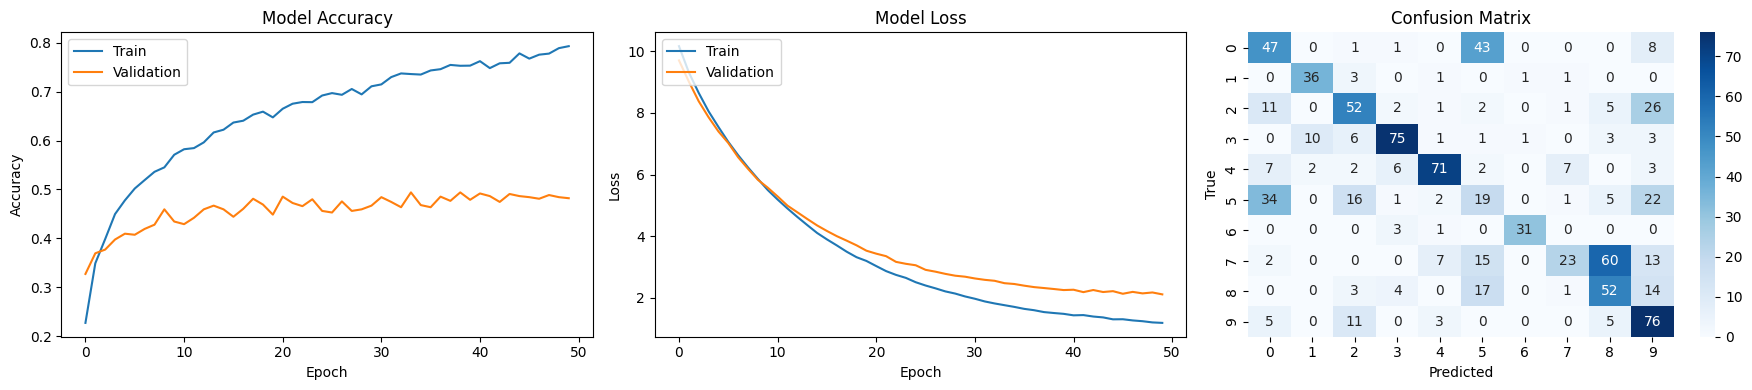

Fold 2 Test Accuracy: 0.5428

Training fold 3...
Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 30s 548ms/step - accuracy: 0.1884 - loss: 10.3897 - val_accuracy: 0.3051 - val_loss: 9.7180
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 29s 545ms/step - accuracy: 0.3204 - loss: 9.4992 - val_accuracy: 0.3909 - val_loss: 9.0328
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 30s 550ms/step - accuracy: 0.3935 - loss: 8.7727 - val_accuracy: 0.3818 - val_loss: 8.4580
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 30s 548ms/step - accuracy: 0.4395 - loss: 8.1850 - val_accuracy: 0.4222 - val_loss: 7.9150
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 30s 548ms/step - accuracy: 0.4818 - loss: 7.6270 - val_accuracy: 0.4242 - val_loss: 7.4748
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 30s 552ms/step - accuracy: 0.5089 - loss: 7.1314 - val_accuracy: 0.4313 - val_loss: 7.0171
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 30s 549ms/step - accuracy: 0.5268 - loss: 6.7130 - val_accuracy: 0.4525 - val_loss: 6.6578
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 30s 546ms

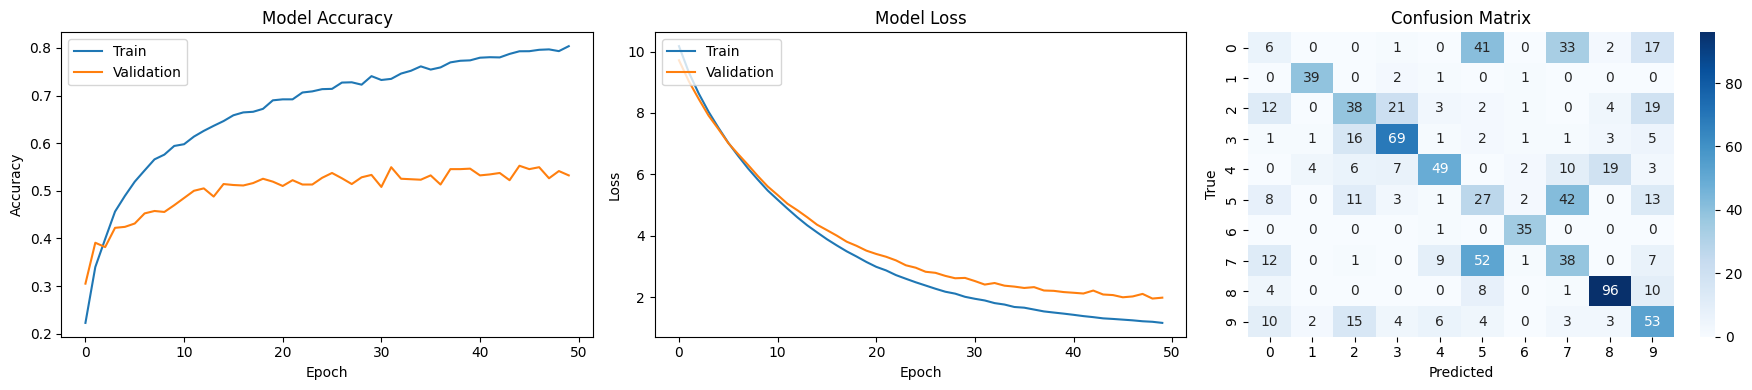

Fold 3 Test Accuracy: 0.4865

Training fold 4...
Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 30s 554ms/step - accuracy: 0.1813 - loss: 10.3533 - val_accuracy: 0.2233 - val_loss: 9.6914
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 30s 549ms/step - accuracy: 0.3217 - loss: 9.4730 - val_accuracy: 0.2927 - val_loss: 8.9758
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 29s 543ms/step - accuracy: 0.3899 - loss: 8.7690 - val_accuracy: 0.3932 - val_loss: 8.4033
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 30s 547ms/step - accuracy: 0.4334 - loss: 8.2059 - val_accuracy: 0.4177 - val_loss: 7.8727
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 30s 555ms/step - accuracy: 0.4499 - loss: 7.6709 - val_accuracy: 0.4199 - val_loss: 7.3842
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 44s 612ms/step - accuracy: 0.4846 - loss: 7.1991 - val_accuracy: 0.4359 - val_loss: 6.9558
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 31s 579ms/step - accuracy: 0.5111 - loss: 6.7589 - val_accuracy: 0.4476 - val_loss: 6.5265
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 30s 556ms

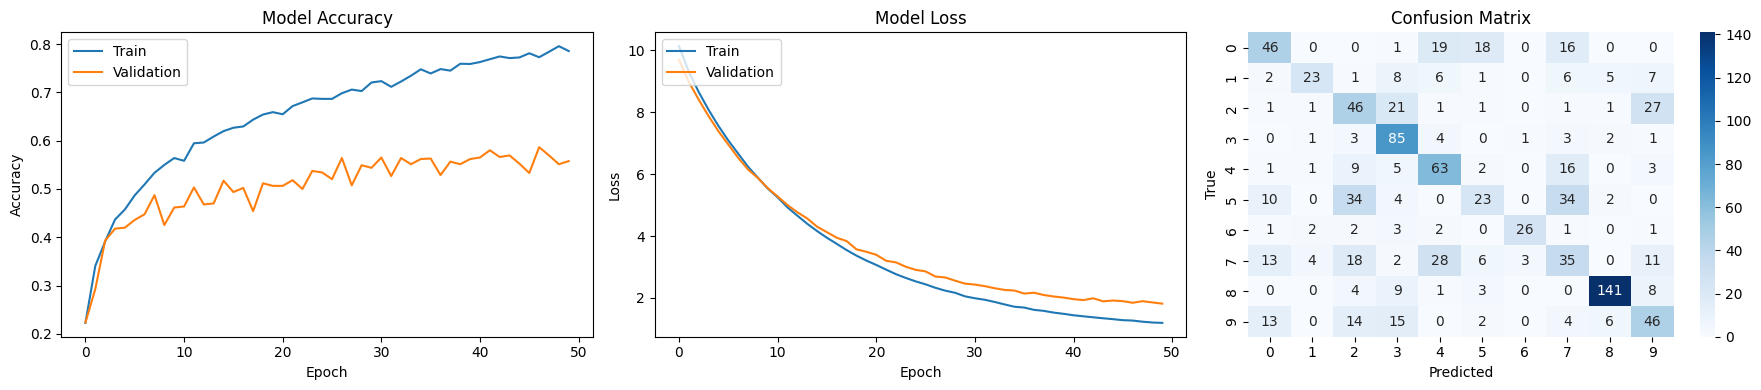

Fold 4 Test Accuracy: 0.5394

Training fold 5...
Epoch 1/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 24s 416ms/step - accuracy: 0.1635 - loss: 10.4050 - val_accuracy: 0.2722 - val_loss: 9.7370
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 23s 417ms/step - accuracy: 0.2990 - loss: 9.5330 - val_accuracy: 0.3548 - val_loss: 8.9930
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 23s 412ms/step - accuracy: 0.3734 - loss: 8.8078 - val_accuracy: 0.4046 - val_loss: 8.3876
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 24s 434ms/step - accuracy: 0.4346 - loss: 8.1945 - val_accuracy: 0.4265 - val_loss: 7.8920
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 23s 419ms/step - accuracy: 0.4742 - loss: 7.6591 - val_accuracy: 0.4228 - val_loss: 7.3958
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 23s 420ms/step - accuracy: 0.5008 - loss: 7.1643 - val_accuracy: 0.4338 - val_loss: 6.9867
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 23s 423ms/step - accuracy: 0.5092 - loss: 6.7469 - val_accuracy: 0.4557 - val_loss: 6.6088
Epoch 8/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 23s 419ms

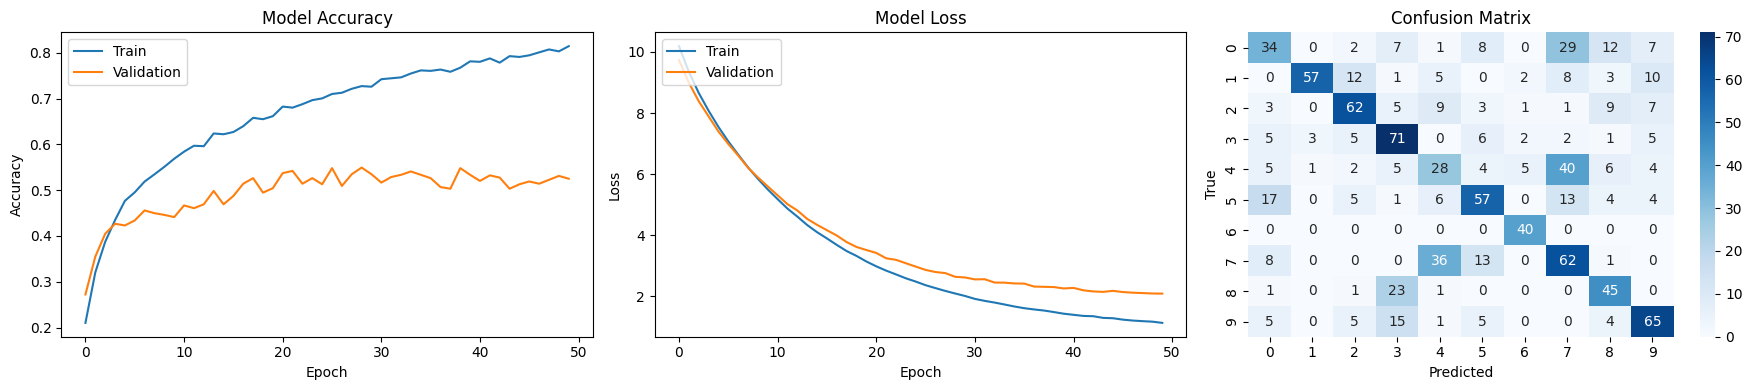

Fold 5 Test Accuracy: 0.5566

Training fold 6...
Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 49s 857ms/step - accuracy: 0.1489 - loss: 10.3801 - val_accuracy: 0.3246 - val_loss: 9.7313
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 47s 840ms/step - accuracy: 0.3264 - loss: 9.5106 - val_accuracy: 0.3962 - val_loss: 9.0075
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 47s 836ms/step - accuracy: 0.3844 - loss: 8.7900 - val_accuracy: 0.4236 - val_loss: 8.4323
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 47s 843ms/step - accuracy: 0.4320 - loss: 8.1796 - val_accuracy: 0.4833 - val_loss: 7.8642
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 49s 879ms/step - accuracy: 0.4638 - loss: 7.6250 - val_accuracy: 0.4976 - val_loss: 7.3877
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 47s 843ms/step - accuracy: 0.4805 - loss: 7.1394 - val_accuracy: 0.5048 - val_loss: 6.9345
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 30s 525ms/step - accuracy: 0.5130 - loss: 6.6823 - val_accuracy: 0.4821 - val_loss: 6.5426
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 358ms

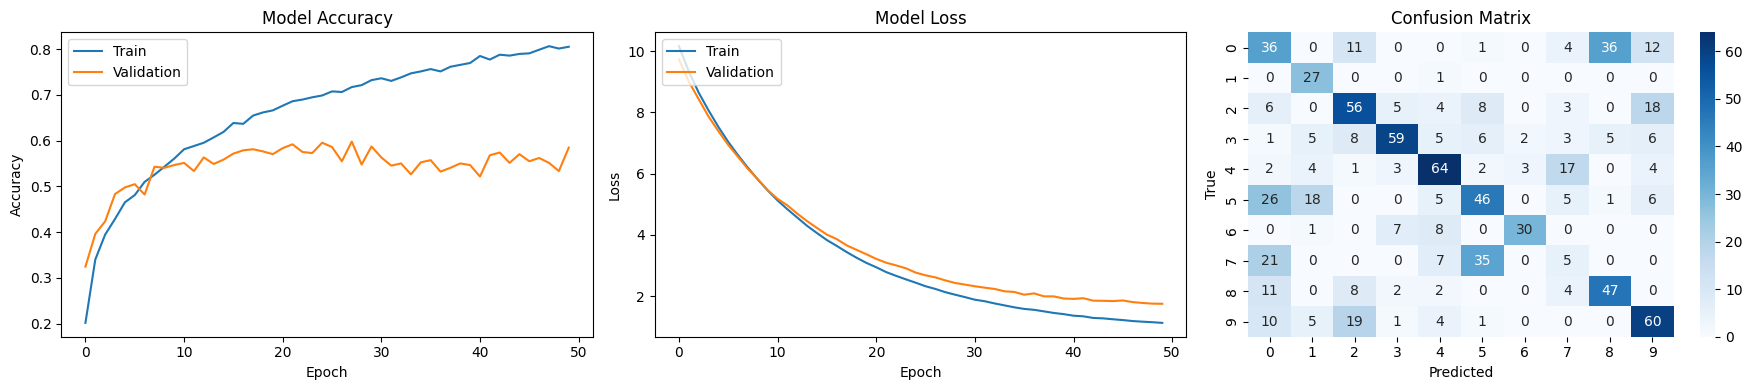

Fold 6 Test Accuracy: 0.5225

Training fold 7...
Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 369ms/step - accuracy: 0.1993 - loss: 10.3179 - val_accuracy: 0.3871 - val_loss: 9.4504
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 373ms/step - accuracy: 0.3088 - loss: 9.4338 - val_accuracy: 0.4702 - val_loss: 8.6976
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 372ms/step - accuracy: 0.3804 - loss: 8.7522 - val_accuracy: 0.4777 - val_loss: 8.1052
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 372ms/step - accuracy: 0.4402 - loss: 8.1178 - val_accuracy: 0.5496 - val_loss: 7.5768
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 371ms/step - accuracy: 0.4633 - loss: 7.5784 - val_accuracy: 0.4988 - val_loss: 7.1121
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 375ms/step - accuracy: 0.5071 - loss: 7.0644 - val_accuracy: 0.5484 - val_loss: 6.7097
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 377ms/step - accuracy: 0.5082 - loss: 6.6466 - val_accuracy: 0.5471 - val_loss: 6.3278
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/st

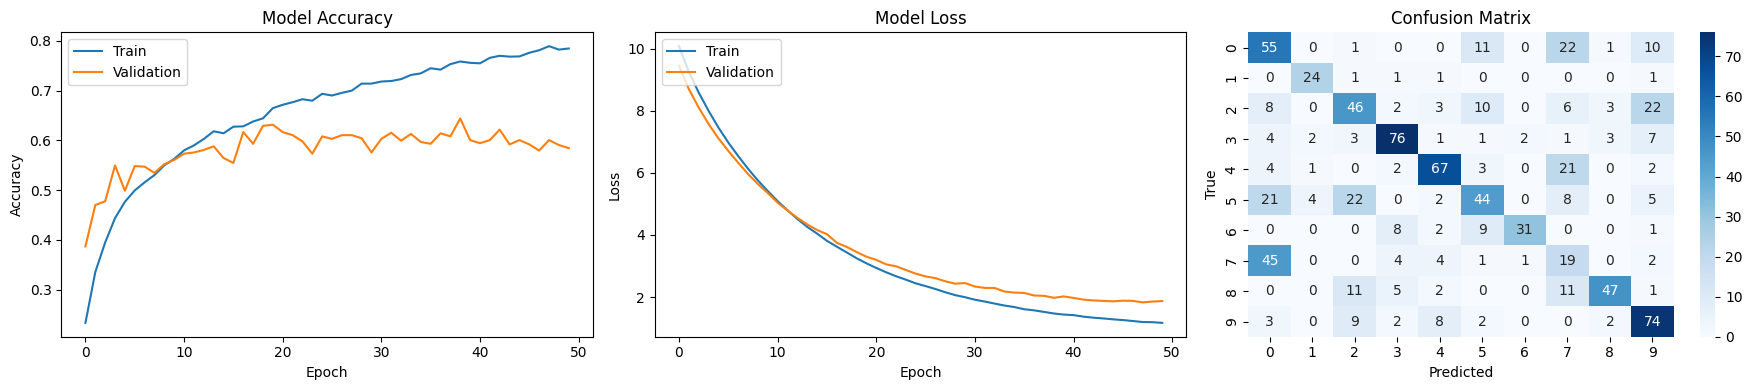

Fold 7 Test Accuracy: 0.5764

Training fold 8...
Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 363ms/step - accuracy: 0.1755 - loss: 10.3598 - val_accuracy: 0.2831 - val_loss: 9.5581
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 356ms/step - accuracy: 0.3238 - loss: 9.4837 - val_accuracy: 0.3529 - val_loss: 8.8217
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 361ms/step - accuracy: 0.3836 - loss: 8.7878 - val_accuracy: 0.3799 - val_loss: 8.2244
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 364ms/step - accuracy: 0.4248 - loss: 8.1714 - val_accuracy: 0.4240 - val_loss: 7.6964
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 366ms/step - accuracy: 0.4521 - loss: 7.6343 - val_accuracy: 0.4350 - val_loss: 7.1843
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 364ms/step - accuracy: 0.4914 - loss: 7.1137 - val_accuracy: 0.4326 - val_loss: 6.7501
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 367ms/step - accuracy: 0.4988 - loss: 6.6577 - val_accuracy: 0.4412 - val_loss: 6.3679
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 371ms

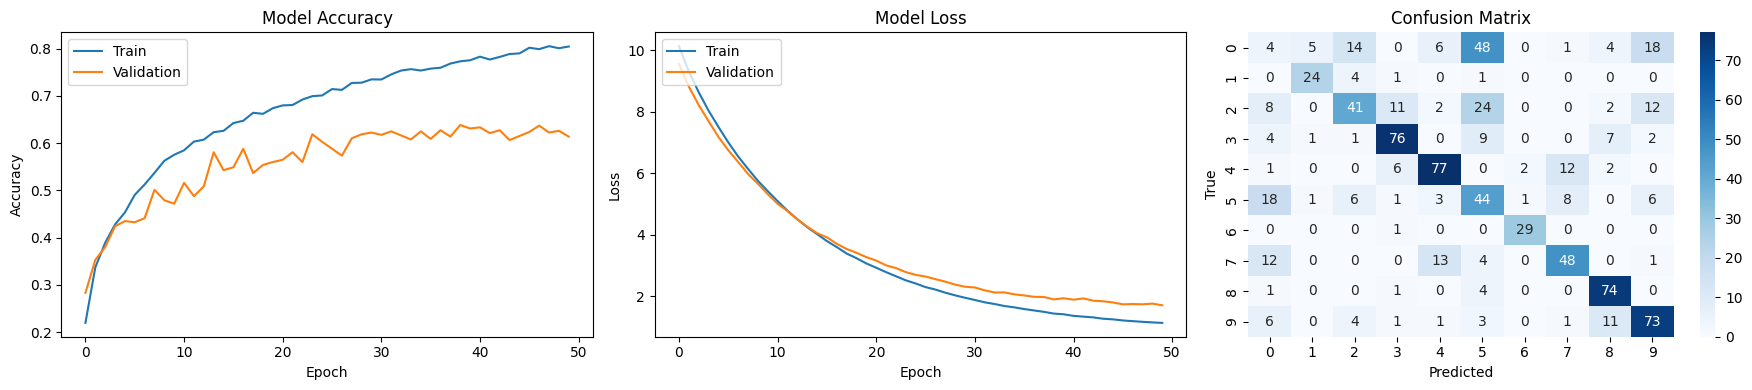

Fold 8 Test Accuracy: 0.6079

Training fold 9...
Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 33s 450ms/step - accuracy: 0.1733 - loss: 10.3901 - val_accuracy: 0.2354 - val_loss: 9.6486
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 356ms/step - accuracy: 0.3203 - loss: 9.4989 - val_accuracy: 0.3978 - val_loss: 8.9425
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 357ms/step - accuracy: 0.3990 - loss: 8.7477 - val_accuracy: 0.4361 - val_loss: 8.3858
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 386ms/step - accuracy: 0.4526 - loss: 8.1325 - val_accuracy: 0.5030 - val_loss: 7.8549
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 365ms/step - accuracy: 0.4787 - loss: 7.6008 - val_accuracy: 0.4385 - val_loss: 7.4279
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 370ms/step - accuracy: 0.5145 - loss: 7.0821 - val_accuracy: 0.5269 - val_loss: 6.9858
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 373ms/step - accuracy: 0.5419 - loss: 6.6281 - val_accuracy: 0.5114 - val_loss: 6.5916
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 377ms

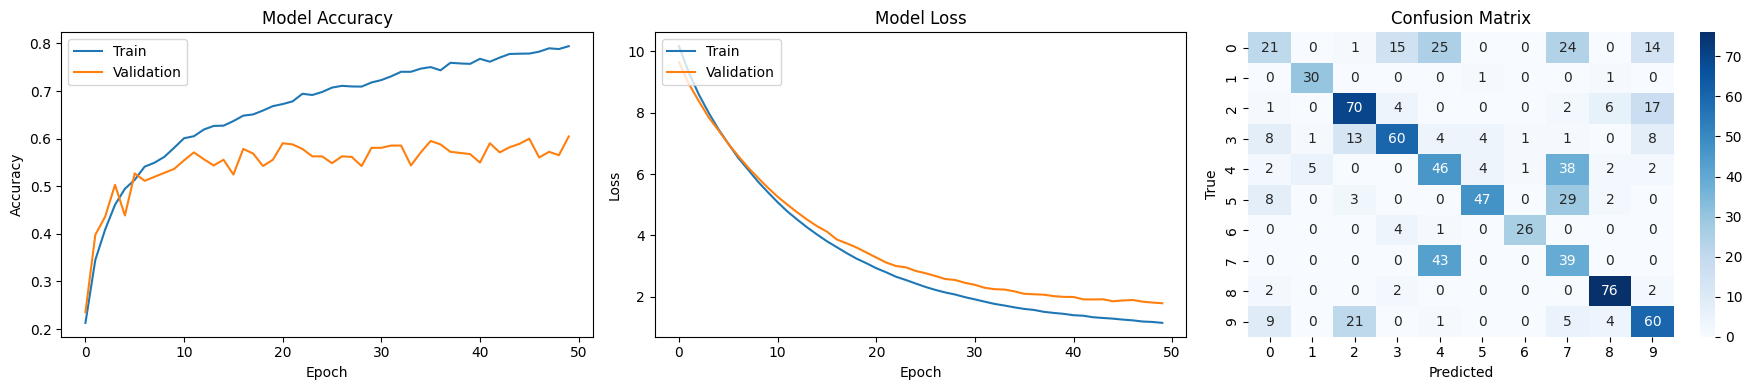

Fold 9 Test Accuracy: 0.5821

Training fold 10...
Epoch 1/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 22s 384ms/step - accuracy: 0.1754 - loss: 10.3465 - val_accuracy: 0.2887 - val_loss: 9.6141
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 21s 385ms/step - accuracy: 0.3288 - loss: 9.4629 - val_accuracy: 0.3643 - val_loss: 8.9151
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 21s 389ms/step - accuracy: 0.4024 - loss: 8.7977 - val_accuracy: 0.4467 - val_loss: 8.3020
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 21s 389ms/step - accuracy: 0.4402 - loss: 8.1602 - val_accuracy: 0.4490 - val_loss: 7.7726
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 21s 389ms/step - accuracy: 0.4766 - loss: 7.6392 - val_accuracy: 0.4857 - val_loss: 7.3296
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 21s 390ms/step - accuracy: 0.4836 - loss: 7.1601 - val_accuracy: 0.5200 - val_loss: 6.8548
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 22s 391ms/step - accuracy: 0.5227 - loss: 6.6981 - val_accuracy: 0.5029 - val_loss: 6.5350
Epoch 8/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/s

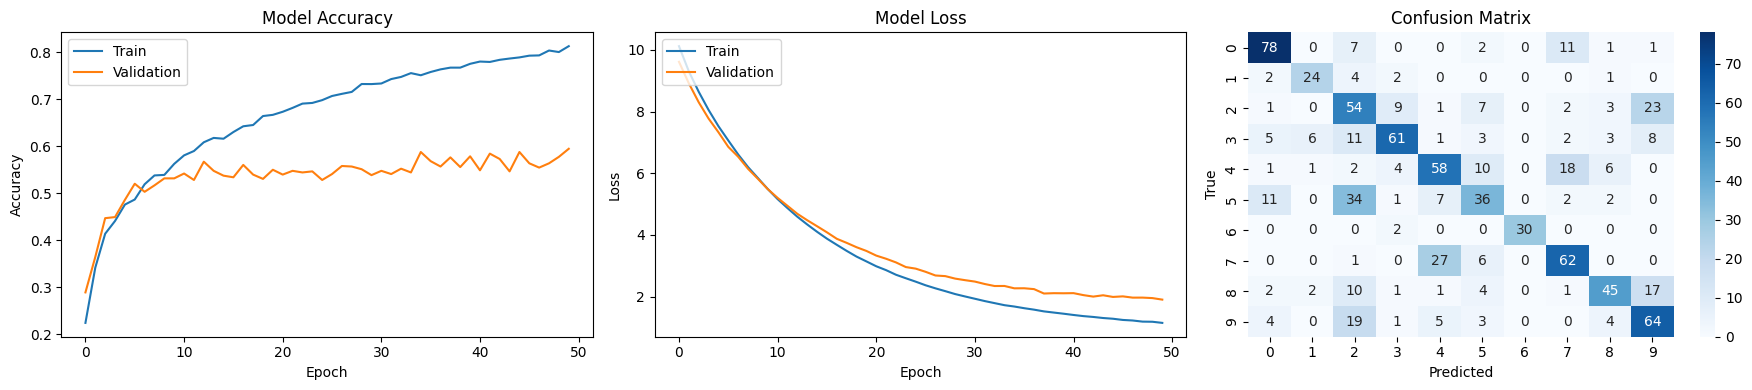

Fold 10 Test Accuracy: 0.6117

Average Accuracy across 10 folds: 56.2384%
Standard Deviation: 3.8282%


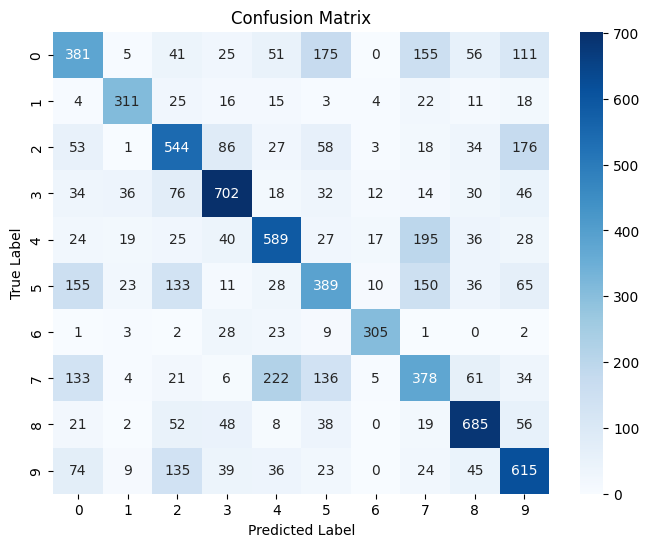

In [9]:
num_folds = 10
fold_accuracies = []
early_stoppings=[]
for i in range(num_folds):
    early_stoppings.append(EarlyStopping(
        monitor='val_loss',  # Metric to monitor; commonly 'val_loss' or 'val_accuracy'
        patience=5 ,          # Number of epochs to wait after no improvement
        restore_best_weights=True,  # Restores model weights to the best epoch with the lowest monitored metric
        verbose=1            # Print messages when early stopping is triggered
    ))
    
y_test_multiclasses = []
predicted_labels_cnns = []
class_labels=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
for i in range(num_folds):
    # Define the test and validation indices
    test_idx = i
    val_idx = (i + 1) % num_folds
    
    # Split the data accordingly
    X_test = X_folds_mel[test_idx]
    y_test = y_folds_mel[test_idx]
    X_val = X_folds_mel[val_idx]
    y_val = y_folds_mel[val_idx]

    # Combine the remaining folds for training
    X_train = np.concatenate([X_folds_mel[j] for j in range(num_folds) if j != test_idx and j != val_idx], axis=0)
    y_train = np.concatenate([y_folds_mel[j] for j in range(num_folds) if j != test_idx and j != val_idx], axis=0)

    # Create a new model instance for each fold
    model = create_model_2d_mel()
    
    # Train the model
    print(f"\nTraining fold {i + 1}...")
    history=model.fit(X_train, y_train, epochs=50, batch_size=128, validation_data=(X_val, y_val), verbose=1, callbacks=[early_stoppings[i]])
    model.save(f"model_fold{i}.keras")

    predictions_cnn = model.predict(X_test)
    predicted_labels_cnn = np.argmax(predictions_cnn, axis=1)

    y_test_multiclass = np.argmax(y_test, axis=1)
    
    if i==0:
        y_test_multiclasses = y_test_multiclass
        predicted_labels_cnns = predicted_labels_cnn
    else:
        y_test_multiclasses = np.concatenate((y_test_multiclasses, y_test_multiclass))
        predicted_labels_cnns = np.concatenate((predicted_labels_cnns, predicted_labels_cnn))

    plot_graphs(history, y_test_multiclass, predicted_labels_cnn, class_labels=class_labels)

    # Evaluate on the test set
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"Fold {i + 1} Test Accuracy: {test_acc:.4f}")
    
    # Save the accuracy for later analysis
    fold_accuracies.append(test_acc)

average_accuracy = np.mean(fold_accuracies)
print(f"\nAverage Accuracy across {num_folds} folds: {average_accuracy*100:.4f}%")
print(f"Standard Deviation: {np.std(fold_accuracies)*100:.4f}%")

# Print average accuracy across all folds
cm = confusion_matrix(y_test_multiclasses, predicted_labels_cnns)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

##### CNN - 2D MFCCs Results


Training fold 1...
Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.1165 - loss: 4.8662 - val_accuracy: 0.1385 - val_loss: 4.7505
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.1646 - loss: 4.7306 - val_accuracy: 0.1689 - val_loss: 4.6338
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.2412 - loss: 4.6091 - val_accuracy: 0.2038 - val_loss: 4.5342
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.2740 - loss: 4.5010 - val_accuracy: 0.2691 - val_loss: 4.4194
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.3193 - loss: 4.4189 - val_accuracy: 0.3536 - val_loss: 4.3234
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.3638 - loss: 4.3025 - val_accuracy: 0.4122 - val_loss: 4.2289
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.3962 - loss: 4.2164 - val_accuracy: 0.4200 - val_loss: 4.1462
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.4303 - loss: 4.1274 - val_accuracy

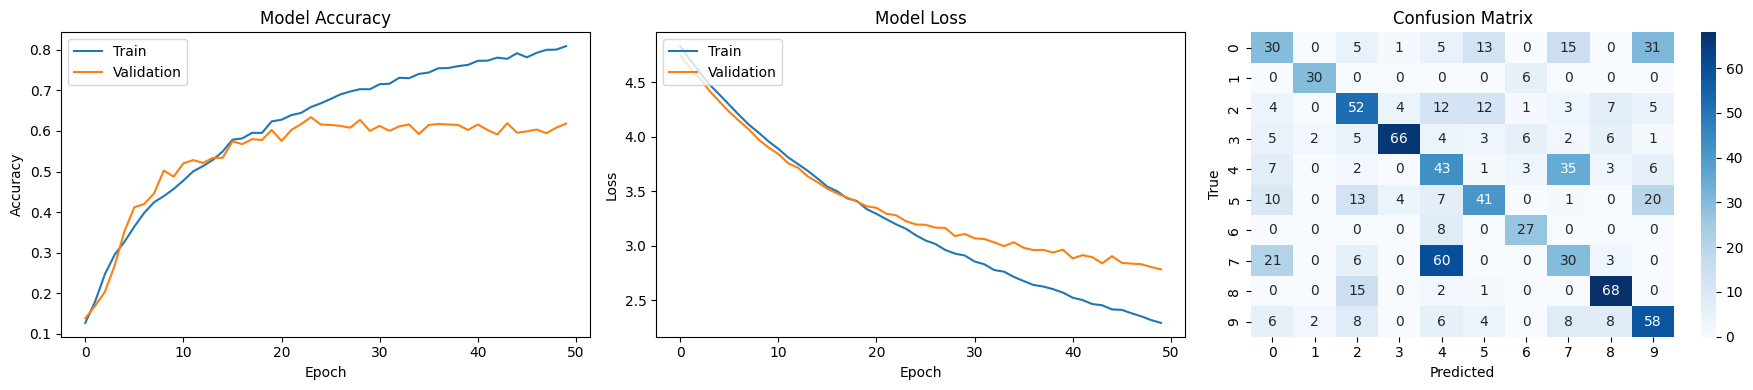

Fold 1 Test Accuracy: 0.5097

Training fold 2...
Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.1164 - loss: 4.8783 - val_accuracy: 0.1470 - val_loss: 4.7782
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.1756 - loss: 4.7539 - val_accuracy: 0.1568 - val_loss: 4.7054
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.2199 - loss: 4.6556 - val_accuracy: 0.1535 - val_loss: 4.6280
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.2523 - loss: 4.5512 - val_accuracy: 0.2335 - val_loss: 4.5528
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.2891 - loss: 4.4577 - val_accuracy: 0.2443 - val_loss: 4.4892
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.3022 - loss: 4.3864 - val_accuracy: 0.2951 - val_loss: 4.4221
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.3294 - loss: 4.3129 - val_accuracy: 0.3016 - val_loss: 4.3654
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.3597 

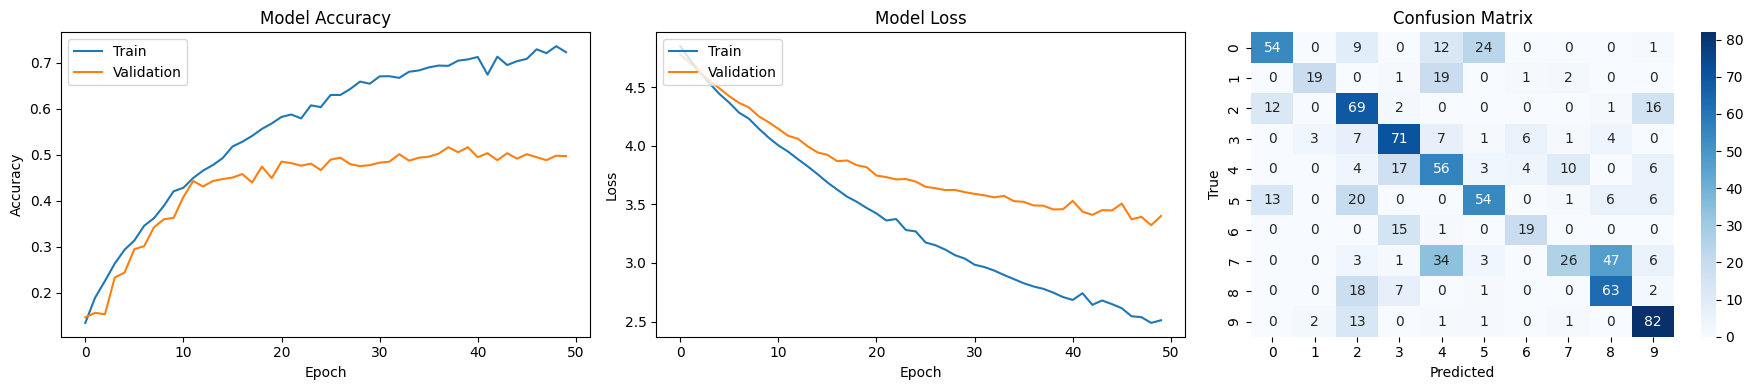

Fold 2 Test Accuracy: 0.5777

Training fold 3...
Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.1197 - loss: 4.8865 - val_accuracy: 0.1394 - val_loss: 4.7879
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.1776 - loss: 4.7504 - val_accuracy: 0.1707 - val_loss: 4.6825
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.2273 - loss: 4.6349 - val_accuracy: 0.2485 - val_loss: 4.5945
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.2779 - loss: 4.5314 - val_accuracy: 0.2889 - val_loss: 4.5248
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.3227 - loss: 4.4187 - val_accuracy: 0.3646 - val_loss: 4.4391
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.3508 - loss: 4.3310 - val_accuracy: 0.3919 - val_loss: 4.3809
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.3774 - loss: 4.2488 - val_accuracy: 0.3798 - val_loss: 4.3329
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.4070 

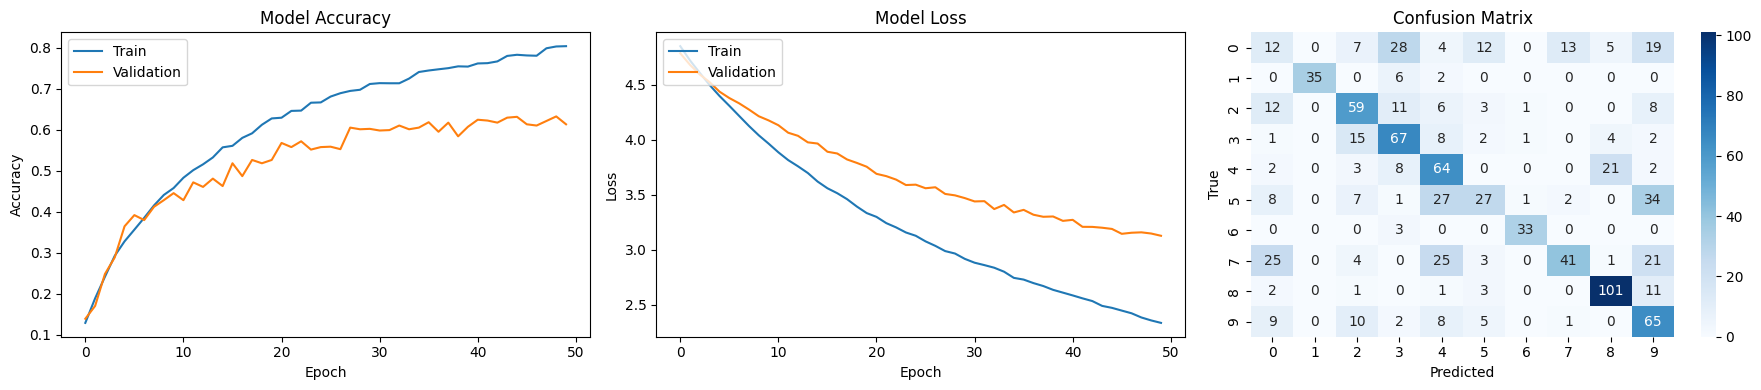

Fold 3 Test Accuracy: 0.5449

Training fold 4...
Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.1205 - loss: 4.8460 - val_accuracy: 0.1410 - val_loss: 4.7445
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.1969 - loss: 4.6966 - val_accuracy: 0.2842 - val_loss: 4.5878
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.2891 - loss: 4.5746 - val_accuracy: 0.3568 - val_loss: 4.4633
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.3265 - loss: 4.4565 - val_accuracy: 0.3397 - val_loss: 4.4142
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 175s 6s/step - accuracy: 0.3729 - loss: 4.3397 - val_accuracy: 0.3825 - val_loss: 4.3371
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.3940 - loss: 4.2666 - val_accuracy: 0.4306 - val_loss: 4.2551
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.4274 - loss: 4.1608 - val_accuracy: 0.4647 - val_loss: 4.1937
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.4629

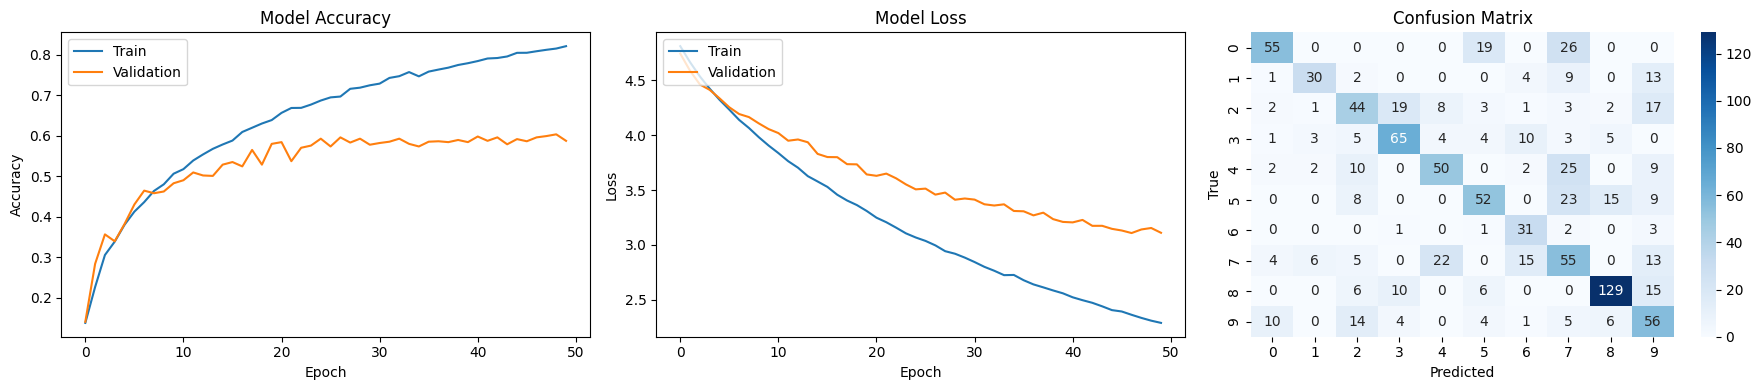

Fold 4 Test Accuracy: 0.5727

Training fold 5...
Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.1014 - loss: 4.8785 - val_accuracy: 0.1215 - val_loss: 4.7632
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.1621 - loss: 4.7433 - val_accuracy: 0.2053 - val_loss: 4.6554
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.2450 - loss: 4.6031 - val_accuracy: 0.2953 - val_loss: 4.5440
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.3147 - loss: 4.4730 - val_accuracy: 0.3341 - val_loss: 4.4525
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 177s 6s/step - accuracy: 0.3453 - loss: 4.3665 - val_accuracy: 0.3876 - val_loss: 4.3811
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.3915 - loss: 4.2731 - val_accuracy: 0.3949 - val_loss: 4.3072
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.4067 - loss: 4.1832 - val_accuracy: 0.4265 - val_loss: 4.2390
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.4409

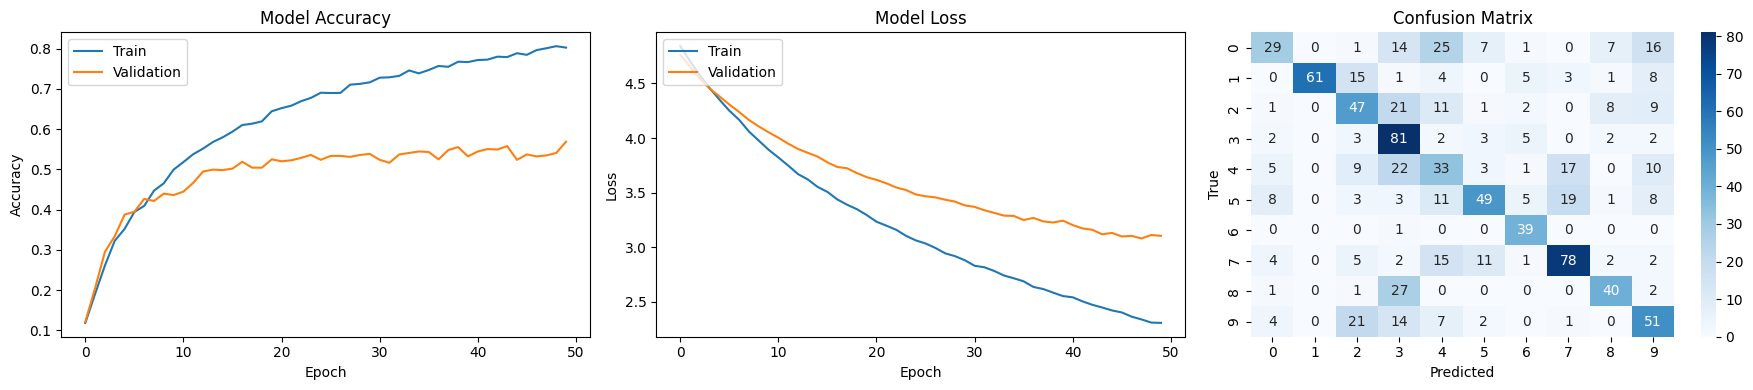

Fold 5 Test Accuracy: 0.5427

Training fold 6...
Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.1258 - loss: 4.8793 - val_accuracy: 0.1671 - val_loss: 4.7780
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.1962 - loss: 4.7407 - val_accuracy: 0.2542 - val_loss: 4.6461
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.2617 - loss: 4.6205 - val_accuracy: 0.2673 - val_loss: 4.5477
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.2957 - loss: 4.5109 - val_accuracy: 0.3258 - val_loss: 4.4624
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.3283 - loss: 4.4339 - val_accuracy: 0.3699 - val_loss: 4.3537
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.3613 - loss: 4.3346 - val_accuracy: 0.4033 - val_loss: 4.2746
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.3943 - loss: 4.2408 - val_accuracy: 0.4200 - val_loss: 4.2030
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.4189 

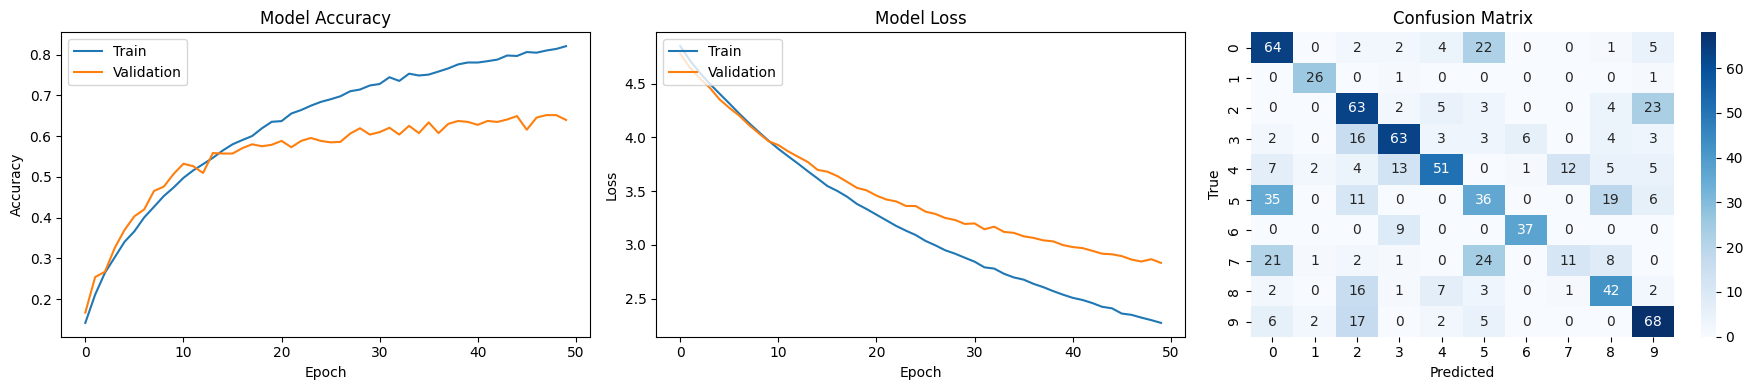

Fold 6 Test Accuracy: 0.5601

Training fold 7...
Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.1189 - loss: 4.8670 - val_accuracy: 0.1464 - val_loss: 4.7439
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.1656 - loss: 4.7425 - val_accuracy: 0.2196 - val_loss: 4.6356
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.2171 - loss: 4.6362 - val_accuracy: 0.2630 - val_loss: 4.5341
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.2550 - loss: 4.5337 - val_accuracy: 0.3176 - val_loss: 4.4560
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.3118 - loss: 4.4467 - val_accuracy: 0.3784 - val_loss: 4.3619
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.3405 - loss: 4.3566 - val_accuracy: 0.4342 - val_loss: 4.2648
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.3758 - loss: 4.2667 - val_accuracy: 0.4442 - val_loss: 4.1845
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.4178 

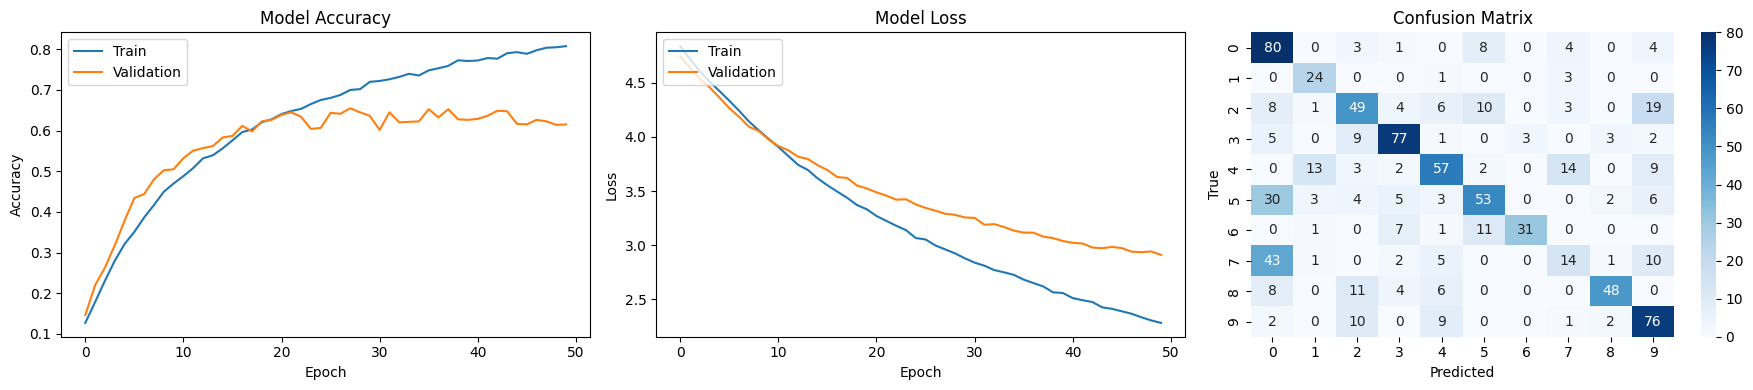

Fold 7 Test Accuracy: 0.6074

Training fold 8...
Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.1208 - loss: 4.8723 - val_accuracy: 0.2034 - val_loss: 4.7827
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.1809 - loss: 4.7425 - val_accuracy: 0.2966 - val_loss: 4.6639
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.2455 - loss: 4.6178 - val_accuracy: 0.3346 - val_loss: 4.5885
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 194s 7s/step - accuracy: 0.3074 - loss: 4.5049 - val_accuracy: 0.4240 - val_loss: 4.4822
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.3509 - loss: 4.3850 - val_accuracy: 0.4571 - val_loss: 4.3952
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.3888 - loss: 4.2949 - val_accuracy: 0.4767 - val_loss: 4.2984
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.4127 - loss: 4.2006 - val_accuracy: 0.5172 - val_loss: 4.2162
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.4363

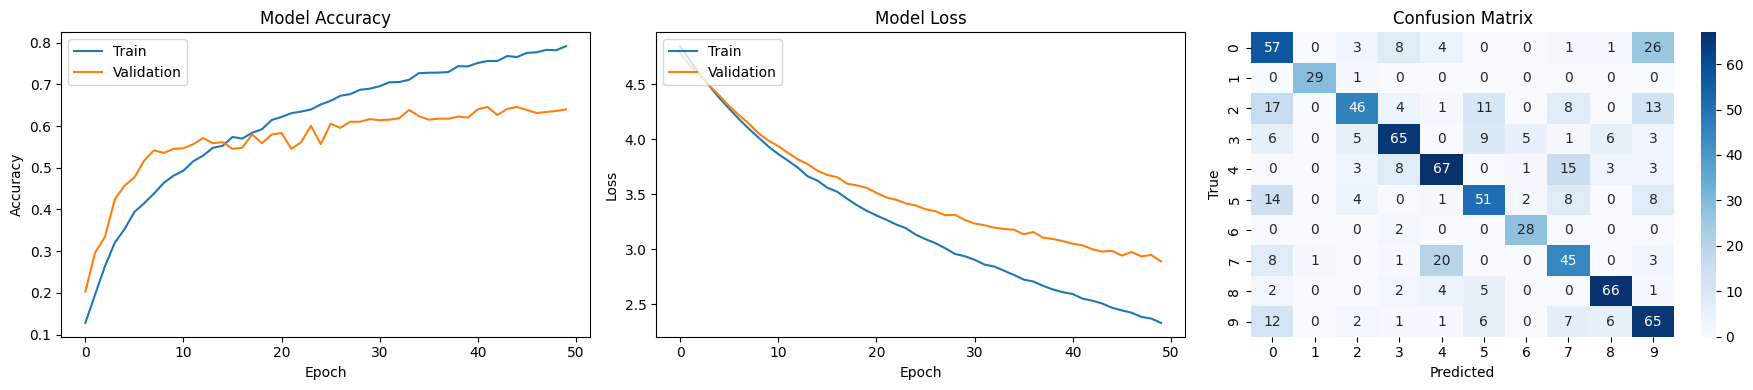

Fold 8 Test Accuracy: 0.6439

Training fold 9...
Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.1090 - loss: 4.8821 - val_accuracy: 0.1195 - val_loss: 4.7372
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.1642 - loss: 4.7531 - val_accuracy: 0.2473 - val_loss: 4.6082
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.2116 - loss: 4.6569 - val_accuracy: 0.2736 - val_loss: 4.5132
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.2543 - loss: 4.5547 - val_accuracy: 0.3297 - val_loss: 4.4242
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.2890 - loss: 4.4748 - val_accuracy: 0.3716 - val_loss: 4.3453
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.3164 - loss: 4.3940 - val_accuracy: 0.3871 - val_loss: 4.2688
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.3419 - loss: 4.2854 - val_accuracy: 0.5066 - val_loss: 4.1812
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.3728 

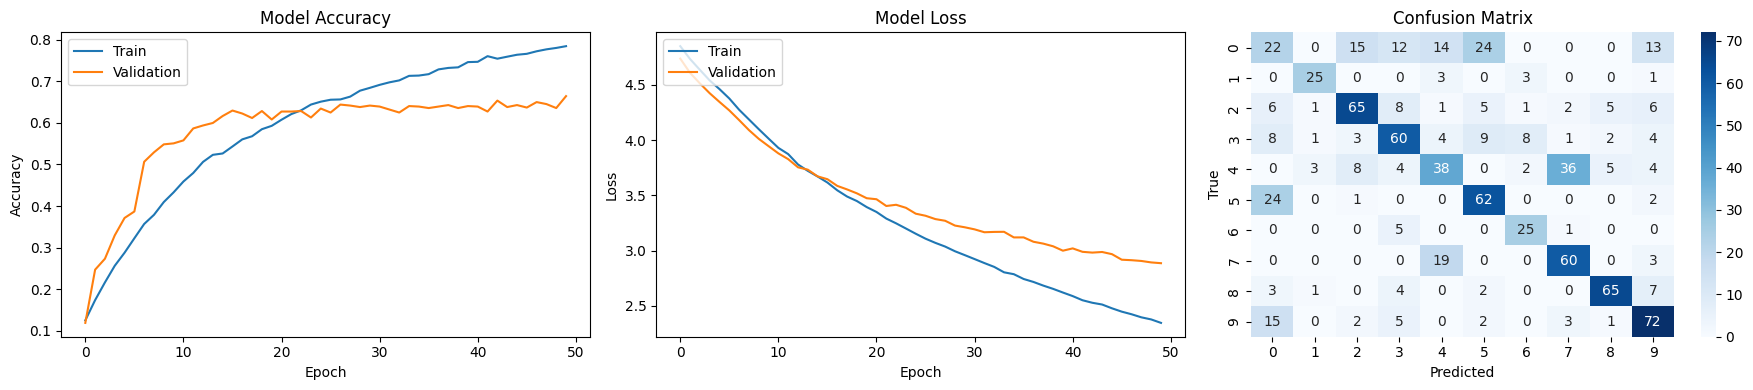

Fold 9 Test Accuracy: 0.6054

Training fold 10...
Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.1100 - loss: 4.8849 - val_accuracy: 0.1260 - val_loss: 4.7872
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.1447 - loss: 4.7803 - val_accuracy: 0.1787 - val_loss: 4.7092
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.1882 - loss: 4.6952 - val_accuracy: 0.2669 - val_loss: 4.6259
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.2441 - loss: 4.5911 - val_accuracy: 0.2806 - val_loss: 4.5605
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.2685 - loss: 4.5152 - val_accuracy: 0.2646 - val_loss: 4.4921
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.3002 - loss: 4.4182 - val_accuracy: 0.3414 - val_loss: 4.4262
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.3108 - loss: 4.3499 - val_accuracy: 0.3379 - val_loss: 4.3676
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.3378

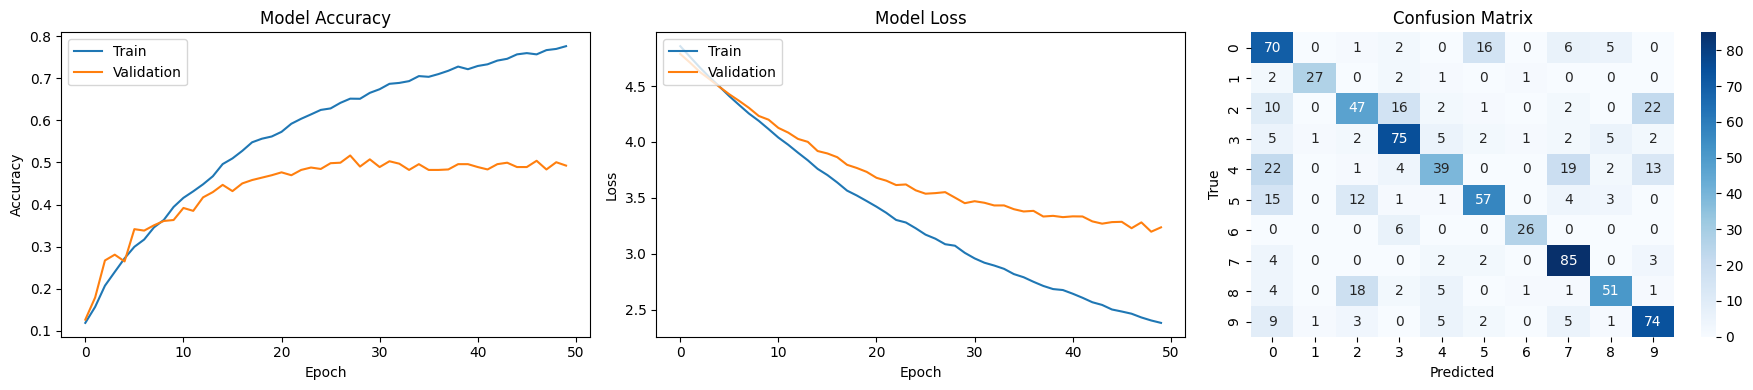

Fold 10 Test Accuracy: 0.6583

Average Accuracy across 10 folds: 58.2293%
Standard Deviation: 4.4241%


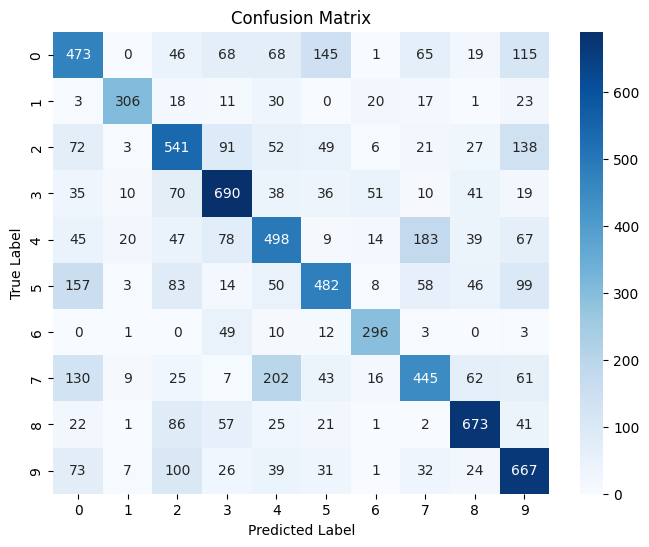

In [5]:
num_folds = 10
fold_accuracies = []
early_stoppings=[]
for i in range(num_folds):
    early_stoppings.append(EarlyStopping(
        monitor='val_loss',  # Metric to monitor; commonly 'val_loss' or 'val_accuracy'
        patience=5 ,          # Number of epochs to wait after no improvement
        restore_best_weights=True,  # Restores model weights to the best epoch with the lowest monitored metric
        verbose=1            # Print messages when early stopping is triggered
    ))
    
y_test_multiclasses = []
predicted_labels_cnns = []
class_labels=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
for i in range(num_folds):
    # Define the test and validation indices
    test_idx = i
    val_idx = (i + 1) % num_folds
    
    # Split the data accordingly
    X_test = X_folds_mfcc[test_idx]
    y_test = y_folds_mfcc[test_idx]
    X_val = X_folds_mfcc[val_idx]
    y_val = y_folds_mfcc[val_idx]

    # Combine the remaining folds for training
    X_train = np.concatenate([X_folds_mfcc[j] for j in range(num_folds) if j != test_idx and j != val_idx], axis=0)
    y_train = np.concatenate([y_folds_mfcc[j] for j in range(num_folds) if j != test_idx and j != val_idx], axis=0)

    # Create a new model instance for each fold
    model = create_model_2d()
    
    # Train the model
    print(f"\nTraining fold {i + 1}...")
    history=model.fit(X_train, y_train, epochs=50, batch_size=256, validation_data=(X_val, y_val), verbose=1, callbacks=[early_stoppings[i]])
    model.save(f"model_fold{i}.keras")

    predictions_cnn = model.predict(X_test)
    predicted_labels_cnn = np.argmax(predictions_cnn, axis=1)

    y_test_multiclass = np.argmax(y_test, axis=1)
    
    if i==0:
        y_test_multiclasses = y_test_multiclass
        predicted_labels_cnns = predicted_labels_cnn
    else:
        y_test_multiclasses = np.concatenate((y_test_multiclasses, y_test_multiclass))
        predicted_labels_cnns = np.concatenate((predicted_labels_cnns, predicted_labels_cnn))

    plot_graphs(history, y_test_multiclass, predicted_labels_cnn, class_labels=class_labels)

    # Evaluate on the test set
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"Fold {i + 1} Test Accuracy: {test_acc:.4f}")
    
    # Save the accuracy for later analysis
    fold_accuracies.append(test_acc)

average_accuracy = np.mean(fold_accuracies)
print(f"\nAverage Accuracy across {num_folds} folds: {average_accuracy*100:.4f}%")
print(f"Standard Deviation: {np.std(fold_accuracies)*100:.4f}%")

# Print average accuracy across all folds
cm = confusion_matrix(y_test_multiclasses, predicted_labels_cnns)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()